## VIDEO TO FRAMES

Esta parte del código requiere la ruta donde se aloja el video, y genera los frames de los videos para el Método 1 y Método 2, no es necesario recortar los videos, o eliminar los frames (el código hace una limpieza  y no procesa los primeros y los últimos frames de cada video, es decir tomar solo los frames entre el 40% y el 80 % del video para evitar movimientos al principio o al final)

Solo cambiar la ruta del video

In [10]:
import cv2
import os

# Carpeta con los videos a los que se les quiere extraer los frames
folder_path = r"D:\Tecnicas_observacionales\Seeing\videos\Videos_diciembre"
filenames = [file for file in os.listdir(folder_path)]
for filename in filenames:
    filename = filename[:-4]
    print(filename)
    video_path = os.path.join(folder_path, f"{filename}.avi")

    video_name = os.path.splitext(os.path.basename(video_path))[
        0
    ]  # Extraer el nombre del archivo para usar como nombre de la carpeta

    output_folder = os.path.join(folder_path, "frames", video_name)  # Crear una carpeta con el nombre del video si no existe
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
        except OSError:
            print("Error: Creating directory of data")
            exit(1)

    # Abrir el video
    cam = cv2.VideoCapture(video_path)

    # Inicializar el contador de frames
    currentframe = 0

    print(f"\n Inicio de la extracción de frames")

    while True:
        # Leer un frame del video
        ret, frame = cam.read()

        if ret:
            # Si hay frames disponibles, continuar creando imágenes
            name = os.path.join(output_folder, f"frame{currentframe}.jpg")
            # print(f"Creating... {name}") #Mostrar los frames creados

            # Guardar la imagen extraída
            cv2.imwrite(name, frame)

            # Incrementar el contador de frames
            currentframe += 1
        else:
            print("\n Extracción de frames completada")
            print(f"\n {currentframe} frames generados")
            print(f"          ....            ")
            break

    # Liberar todos los recursos y cerrar ventanas una vez terminado
    cam.release()
    cv2.destroyAllWindows()

2024-12-19-Aldebaran_19_09

 Inicio de la extracción de frames

 Extracción de frames completada

 6680 frames generados
          ....            
2024-12-19-Aldebaran_19_27

 Inicio de la extracción de frames

 Extracción de frames completada

 3661 frames generados
          ....            
2024-12-19-Aldebaran_19_32

 Inicio de la extracción de frames

 Extracción de frames completada

 3633 frames generados
          ....            
2024-12-19-Capella_19_06

 Inicio de la extracción de frames

 Extracción de frames completada

 2901 frames generados
          ....            
2024-12-19-Hamal_20_04

 Inicio de la extracción de frames

 Extracción de frames completada

 6072 frames generados
          ....            
2024-12-19-Hamal_20_07

 Inicio de la extracción de frames

 Extracción de frames completada

 5581 frames generados
          ....            
fr

 Inicio de la extracción de frames

 Extracción de frames completada

 0 frames generados
          ....            


## Frames Analysis

Aquí se determina la distancia entre los spot de las estrellas del método 1 y el método 2. 

Se requiere insertar la ruta donde se guardaron los frames

Sarazin & Roddier (1990), definen la varianza en términos del movimiento total como:

$$
\sigma^{2} = 2B_{\alpha}(0,0) = 0.358 \left(\frac{\lambda}{r_0}\right)^{5/3} \left(\frac{\lambda}{D}\right)^{1/3}

$$

Donde $D$ es el diámetro de las aperturas 4.2 cm, $r_0$ es el parámetro de Fried y $\lambda$ es la longitud de onda, en este caso el visible , 0.5 $\mu$ m

Seeing :
$$
FWHM = \Delta \theta = 0.98 \lambda / r_0
$$

In [132]:
"""________________Distance_IMG______________
Programa que construye el histograma de frecuencias de la separación 
entre dos "spots" (objetos) en el DIMM."""

"""_________________Libraries________________________"""
import cv2
import os
import glob
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance as dist
from astropy.stats import mad_std
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from tqdm import tqdm

"""__________________________________________________"""


"""__________________FUNCTIONS_______________________"""

def identify_stars_and_distance(image_path, thresh, plot=False):
    # Cargar imagen con filtro en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image[:50, :200] = 0 #eliminar borde de la imagen primeros 50 px en y y 200 en x

    # Calcular la desviación estándar (ruido de fondo) de la imagen sin el fondo
    std, median = mad_std(image), np.median(image)

    # Aplicar un umbral para binarizar la imagen y destacar los objetos (estrellas) Este parámetro se puede variar según la intensidad de la estrella
    _, thresh = cv2.threshold(image, thresh*median , 255, cv2.THRESH_BINARY)

    # Encontrar los contornos de los objetos (estrellas)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar unicamente los dos contornos más grandes detectados (asumiendo que son las estrellas)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    # Obtener los centros de las dos estrellas
    star_centers = []  #crear un vector para guardar los centros
    for contour in contours:
        M = cv2.moments(contour) #calcula los momentos del contorno, función de Open CV
        if M["m00"] != 0:  # moo es el area del contorno
            cX = int(M["m10"] / M["m00"])  #m10 es el momento espacial para calcular las coordenadas del centroide
            cY = int(M["m01"] / M["m00"])  #m01 es el momento espacial para calcular las coordenadas del centroide
            star_centers.append((cX, cY)) #guardar las coordenadas de los centros encontrados

    # Calcular la distancia entre las dos estrellas
    if len(star_centers) == 2:
        pixel_distance = dist.euclidean(star_centers[0], star_centers[1])
        if plot:
            # Display the image
            plt.imshow(image, cmap='gray')
            # print(star_centers)
            plt.plot([star_centers[0][0], star_centers[1][0]], [star_centers[0][1], star_centers[1][1]], 'ro', mfc='none')
            plt.tight_layout()
            plt.axis('off')
            # plt.savefig('hm.png', dpi=400)
            plt.show()        

        return(pixel_distance)
    else:
        print("No se encontraron estrellas.")
        return 0

def normal_distribution(distances, scale_size, lamb, Dhole, dsep, plot=False):
    # Eliminar distancias cero
    distances = distances[distances != 0]

    # Ajuste de los datos a una distribución normal
    mu, std = norm.fit(distances)

    # Normalizar la desviación estándar (en arcsec)
    sigma_sc = std * scale_size

    # FWHM
    fwhm = 2.355 * std

    # Parámetro de Fried (r0 en cm)
    r_0 = (((sigma_sc/206264.8)**2)/((2*lamb**2)*(0.179*Dhole**(-1/3)-0.145*dsep**(-1/3))))**(-3/5)

    # Seeing sin corregir por el cenit
    theta = 0.98 * (lamb / r_0) * 206264.8

    # Plotear si se desea
    if plot:
        weights = np.ones_like(distances) / len(distances)
        count, bins, ignored = plt.hist(distances, weights=weights, bins=15, alpha=0.6, color="g", edgecolor="black")
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        bin_width = bins[1] - bins[0]
        p_normalized = p * bin_width
        plt.plot(x, p_normalized, "k", linewidth=2)

        plt.title(r"$\mathrm{Histograma:}\ \mu=%.3f,\ \sigma=%.3f,\ \mathrm{FWHM}=%.3f$" % (mu, std, fwhm))
        plt.xlabel("Distancia entre centroides (px)")
        plt.ylabel("Frecuencia")
        plt.text(0.15, 0.9, f"Placa: {scale_size} \"/px", transform=plt.gca().transAxes, fontsize=12, color='black', ha='center')
        plt.show()

    return mu, std, sigma_sc, fwhm, r_0, theta

# Definir una funcion para extraer el numero del frame del nombre del archivo
def extract_frame_number(filename):
    match = re.search(r'frame(\d+)\.jpg', filename)
    return int(match.group(1)) if match else -1

In [124]:
Dhole = 4.2  #<----------------diametro de la apertura  en cm
dsep = 14.4  #<----------------diametro de la separacion de las aperturas en cm
lamb = 0.00005  #<-------------longitud de onda en micrometros (cm)
scale_size = 1.12 #<---------- ingresar escala de camara segundos de arco por px ('' /px)

Corrección por video

Factor de recorte, 6000/1920 = 3.125
Por relación de frame del video con tamaño captura


Unidades radianes o unidades de angulo
Longitudinal o transversal




G-1_altair_270824_21_09_DSC_0019_mascara
Se encontraron 2802 frames(.jpg) se procesarán del 1120 al 2241

 :: CONSTRUYENDO EL HISTOGRAMA :: 



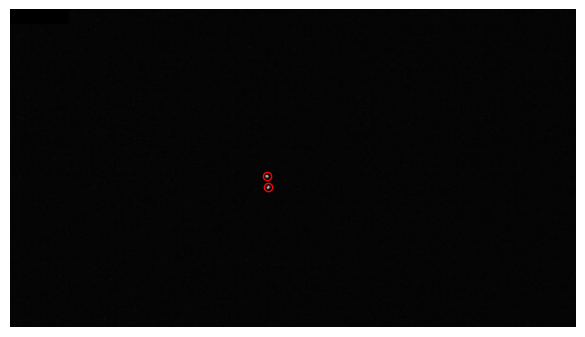

KeyboardInterrupt: 

In [133]:
"""_____________________MAIN_________________________"""
folder = r"D:\Tecnicas_observacionales\Seeing\videos\Videos_Bogota_Agosto_Septiembre\frames"  # <--------------AQUI SE CAMBIA LA RUTA DONDE SE ENCUENTRAN LOS FRAMES
output_folder = r"D:\Tecnicas_observacionales\Seeing\videos\Videos_Bogota_Agosto_Septiembre\frames"  # Carpeta de salida para los archivos .dat

files = np.sort([file for file in os.listdir(folder)])

values = np.zeros((len(files),6), dtype=object)
ff = -1

threshold = []
seeing = []
sigma = []
sigma_sec = []
fried = []
fwhm = []

thrhld = 8  # <------------------------Cambiar el valor para ajustar el umbral del threshold

for filename in files:
    ff+=1
    plotit = True  # <-----------------Cambiar a True para visualizar los frames con las estrellas identificadas

    # Abrir carpeta donde se encuentran los frames del video
    carpeta = f"{folder}/{filename}"
    print(filename)

    # Busqueda de los archivos .jpg
    archivos = glob.glob(carpeta + r"/*.jpg")

    # Ordenar los archivos numéricamente por el número de frame en el nombre asi (0, 1, 2, 3, ...)
    archivos.sort(key=extract_frame_number)

    # Definir los frames que se procesaran, eliminar errores al inicio y fin
    start = int(len(archivos)*0.4) #<-----------------cambiar para ajustar el rango de procesamiento
    end = int(len(archivos)*0.8)   #<-----------------cambiar para ajustar el rango de procesamiento

    nombres = []
    for j in archivos:
        if carpeta in j:
            nombres.append(j.replace(carpeta, ""))

    if nombres != []:
        l = len(nombres)
        print(f"Se encontraron {l} frames(.jpg) se procesarán del {start} al {end}")
        print("\n :: CONSTRUYENDO EL HISTOGRAMA :: \n")
    else:
        print("Su carpeta no tiene archivos .jpg")

    distances = []

    for k in range(start, end):
        # Usar la función en un frame
        dis = identify_stars_and_distance(archivos[k],thrhld, plotit)

        distances.append(dis)  

        if dis!=0:
            plotit = False
    # print(distances)
    distances = np.array(distances)
    no_stars = len(np.where(distances==0)[0])
    # print(f'No se encontraron estrellas en {no_stars} frames, es decir en el {round(no_stars/(end-start+1)*100,2)}% de ellos')

    # Graficar el histograma y la PDF ajustada
    mu, std, sigma_sc, fuwhama, r_0, theta = normal_distribution(distances, scale_size, lamb, Dhole, dsep, plot=plotit)

    threshold.append((filename, thrhld))
    sigma.append((filename, std))
    sigma_sec.append((filename,sigma_sc))
    fried.append((filename, r_0))
    fwhm.append((filename, fuwhama))
    seeing.append((filename, theta))

# Guardar los datos en un archivo .dat dentro de la misma carpeta
output_file = os.path.join(output_folder, f"seeing_sigma.dat")

with open(output_file, "w") as f:
    f.write("Filename\tThreshold\tSigma(px)\tSigma(sec)\tr_0(cm)\tFWHM\tSeeing_sin_corregir\n")  # Usar \t para tabulaciones
    for (file_threshold, value_threshold),(file_sigma, value_sigma), (file_sigma_sec, value_sigma_sec), (file_fried, value_fried),(file_fwhm, value_fwhm), (file_seeing, value_seeing) in zip(threshold,sigma, sigma_sec, fried, fwhm, seeing):
        f.write(f"{file_seeing}\t{value_threshold:.3f}\t{value_sigma:.3f}\t{value_sigma_sec:.3f}\t{value_fried:.3f}\t{value_fwhm:.3f}\t{value_seeing:.3f}\n")

# Analisis de threshold para DIMM

Analizaremos los archivos dat generados  para los Threshold desde 1.5 hasta 8 veces la mediana


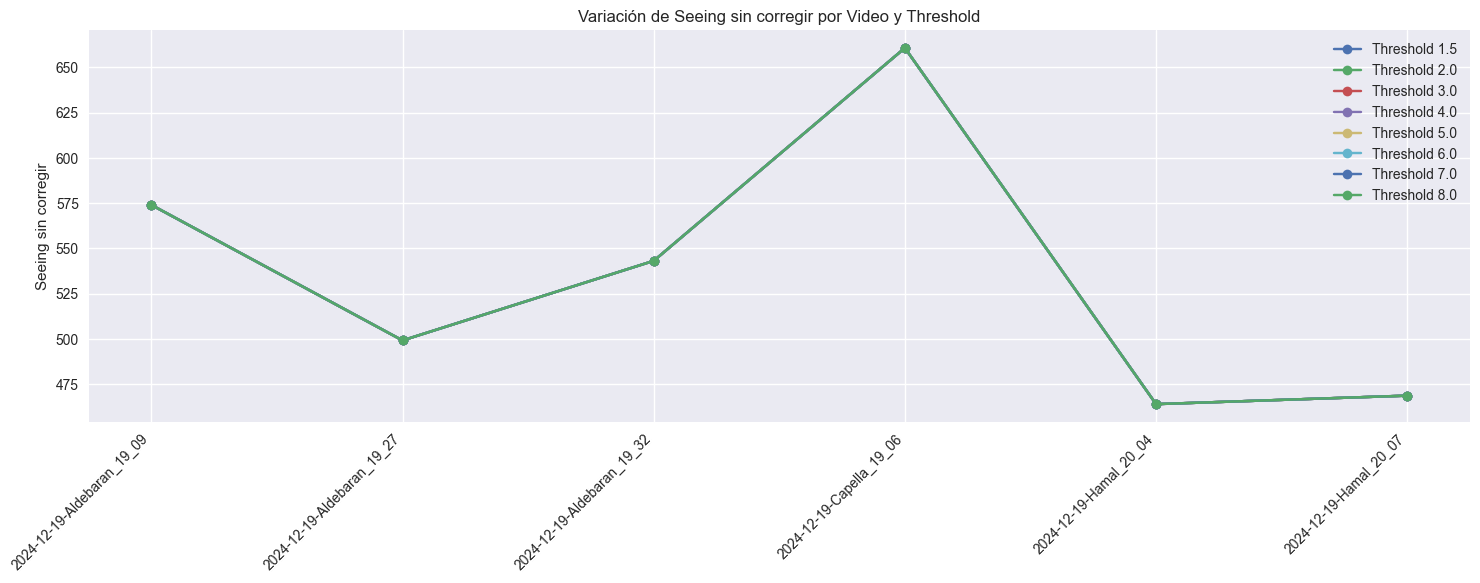

Gráfico guardado en: D:\Tecnicas_observacionales\Seeing\results\videos_diciembre\seeing_sigma_comparison.png


In [23]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuración inicial
path = r"D:\Tecnicas_observacionales\Seeing\data\videos_diciembre"
output_dir = r"D:\Tecnicas_observacionales\Seeing\results\videos_diciembre"  # Cambia esto a tu directorio de salida deseado
os.makedirs(output_dir, exist_ok=True)

# Cargar todos los archivos de datos
file_pattern = os.path.join(path, "*_seeing_sigma.dat")
files = glob.glob(file_pattern)

# Leer todos los datos y combinar en un solo DataFrame
all_data = []
for file in files:
    # Extraer el valor de threshold del nombre del archivo
    threshold = os.path.basename(file).split("_")[0]
    df = pd.read_csv(file, sep='\t')
    df['Threshold'] = float(threshold)
    all_data.append(df)

combined_df = pd.concat(all_data)

# Ordenar por nombre de archivo y threshold
combined_df.sort_values(['Filename', 'Threshold'], inplace=True)

# Preparar los datos para graficar
videos = combined_df['Filename'].unique()
thresholds = sorted(combined_df['Threshold'].unique())
x = np.arange(len(videos))  # ubicaciones para los videos en el eje x

# Crear gráficos
plt.figure(figsize=(15, 10))

# Gráfico para Seeing sin corregir
plt.subplot(2, 1, 2)
for threshold in thresholds:
    mask = combined_df['Threshold'] == threshold
    seeing_values = combined_df.loc[mask, 'Seeing_sin_corregir'].values
    plt.plot(x, seeing_values, 'o-', label=f'Threshold {threshold}')

plt.xticks(x, videos, rotation=45, ha='right')
plt.ylabel('Seeing sin corregir')
plt.title('Variación de Seeing sin corregir por Video y Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Guardar el gráfico
output_path = os.path.join(output_dir, 'seeing_sigma_comparison.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Gráfico guardado en: {output_path}")

In [24]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Configuración inicial
path = r"D:\Tecnicas_observacionales\Seeing\data\videos_diciembre"
output_dir = r"D:\Tecnicas_observacionales\Seeing\results\videos_diciembre"
os.makedirs(output_dir, exist_ok=True)

# Ver estilos disponibles y seleccionar
print("Estilos disponibles:", plt.style.available)
plt.style.use("seaborn-v0_8")  # Usar estilo moderno

# Cargar y combinar datos
file_pattern = os.path.join(path, "*_seeing_sigma.dat")
files = glob.glob(file_pattern)

all_data = []
for file in files:
    try:
        threshold = os.path.basename(file).split("_")[0]
        df = pd.read_csv(file, sep="\t")
        df["Threshold"] = float(threshold)
        all_data.append(df)
    except Exception as e:
        print(f"Error al procesar {file}: {str(e)}")

if not all_data:
    raise ValueError("No se encontraron datos válidos para graficar")

combined_df = pd.concat(all_data)
combined_df.sort_values(["Filename", "Threshold"], inplace=True)

# Preparar datos
videos = combined_df["Filename"].unique()
thresholds = sorted(combined_df["Threshold"].unique())
x = np.arange(len(videos))

# Crear figura solo para Seeing
plt.figure(figsize=(14, 8))

# Paleta de colores mejorada
colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)))

# Gráfico para Seeing sin corregir - Escala logarítmica
for i, threshold in enumerate(thresholds):
    mask = combined_df["Threshold"] == threshold
    seeing_values = combined_df.loc[mask, "Seeing_sin_corregir"].values
    plt.semilogy(
        x,
        seeing_values,
        "o-",
        linewidth=2.5,
        markersize=8,
        color=colors[i],
        label=f"Threshold {threshold}",
    )

# Configuración del gráfico
plt.xticks(x, videos, rotation=45, ha="right", fontsize=10)
plt.ylabel("Seeing sin corregir [arcsec]", fontsize=12)
plt.title(
    "Variación del Seeing sin corregir por Threshold (escala logarítmica)",
    fontsize=14,
    pad=20,
)
plt.legend(fontsize=10, framealpha=0.9, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, which="both", ls=":", alpha=0.6)

# Ajustar márgenes para evitar cortar etiquetas
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar rectángulo de plot

# Guardar gráfico
output_path = os.path.join(output_dir, "seeing_log_scale.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"Gráfico de Seeing guardado en: {output_path}")

Estilos disponibles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Gráfico de Seeing guardado en: D:\Tecnicas_observacionales\Seeing\results\videos_diciembre\seeing_log_scale.png


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

# Cargar datos
df = pd.read_csv('DIMM_data.txt', sep='\t')

# Convertir las horas a formato datetime ajustando rango
df["Hora_datetime"] = pd.to_datetime(df["Hora"], format="%H:%M")
df["Hora_datetime"] = df["Hora_datetime"].apply(lambda x: x + timedelta(days=1) if x.hour < 18 else x)

# Ordenar por hora
df = df.sort_values(by="Hora_datetime")

# Graficar con barras de error y ajustes solicitados
plt.figure(figsize=(6, 4))
plt.errorbar(
    df["Hora_datetime"],
    df["Seeing"],
    yerr=df["sigma (px) software"],
    fmt="o--",                        # Línea discontinua con marcadores
    ecolor="lightgray",               # Barras de error más claras
    capsize=3,                        # Extensión de las barras de error
    markerfacecolor="none",           # Marcadores sin relleno
    markeredgecolor="black",          # Bordes de los marcadores en negro
    color="black",                    # Línea punteada en negro
    linestyle="--"                    # Estilo de línea discontinua
    
)

# Ajustar formato del eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlim([datetime.strptime("18:00", "%H:%M"), datetime.strptime("01:00", "%H:%M") + timedelta(days=1)])
plt.ylim(0, 8.5)

# Agregar etiquetas
plt.xlabel("Hora (UTC - 5)")
plt.ylabel("Seeing (segundos de arco)")

# Agregar cuadrícula con subdivisiones
plt.grid(which="both", alpha=0.4)     # Cuadrícula principal
plt.minorticks_on()                  # Activar ticks menores
plt.grid(which="minor", alpha=0.2, linestyle=":")  # Cuadrícula secundaria con estilo punteado

# Mostrar gráfico
plt.tight_layout()
plt.show()
